<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/autoencoder-mnist-experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder on MNIST data with TensorFlow 2

* https://blog.keras.io/building-autoencoders-in-keras.html
* https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

dpi = 96
# dpi = 300

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 8)
# mpl.rcParams["figure.dpi"] = dpi
mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15)

font_size=15
title_font_size=25

# https://matplotlib.org/users/colormaps.html
from matplotlib.colors import ListedColormap

colors = ['#FF0000', '#0000FF', '#FFFF00']
cmap = ListedColormap(colors) 

In [2]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [3]:
import tensorflow as tf
print(tf.__version__)

2.1.0-rc1


In [0]:
tf.random.set_seed(42)

In [5]:
!nvidia-smi

Mon Dec 30 17:47:19 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
# https://github.com/AndreasMadsen/python-lrcurve
!pip install -q lrcurve 

In [0]:
from lrcurve import KerasLearningCurve

## MNIST data set

In [8]:
import numpy as np
from tensorflow.keras.datasets import mnist, fashion_mnist

x_res = 28
y_res = 28
image_size = x_res * y_res

# (x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

can not use 2d rep as autoencoder needs to spit out flat image

In [9]:
x_train = x_train.reshape(-1, image_size)
x_test = x_test.reshape(-1, image_size)
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [0]:
def plot_samples(x, y, n_samples=15, labels=None):
  figure = plt.figure()
  for i, index in enumerate(np.random.choice(x_test.shape[0], size=n_samples, replace=False)):
      ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
      ax.imshow(x[index].reshape(x_res, y_res), cmap="binary")
      if labels:
        ax.set_title("{}".format(labels[y[index]]))
      else:
        ax.set_title("{}".format(y[index]))

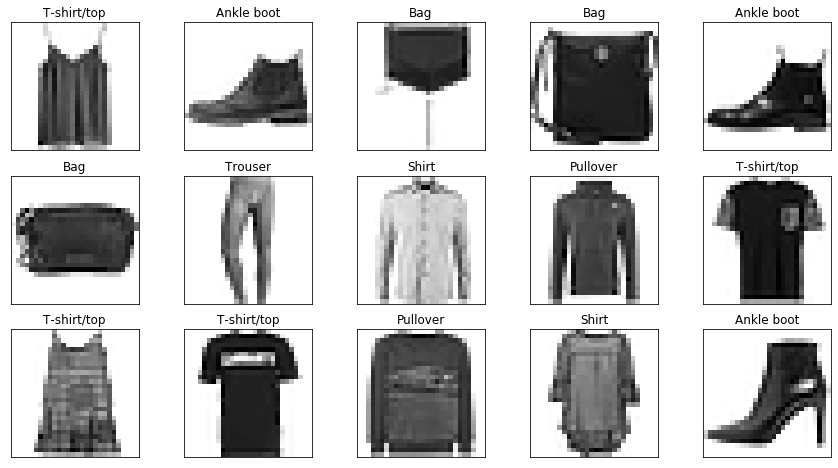

In [11]:
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9


plot_samples(x_train, y_train, labels=fashion_mnist_labels)

autoencoder using functional API

In [12]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten
from tensorflow.keras.models import Model

encoding_dim = 32

# input_img = Input(shape=(28, 28), name='2d_input')
input_img = Input(shape=image_size, name='1d_input')
# flattened = Flatten(name='flattened_input')(input_img)
encoded = Dense(encoding_dim, activation='relu', name='encoder')(input_img)
decoded = Dense(image_size, activation='sigmoid', name='decoder')(encoded)
# reshaped = Reshape((28, 28), name='2d_output')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1d_input (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
encoder (Dense)              (None, 32)                25120     
_________________________________________________________________
decoder (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


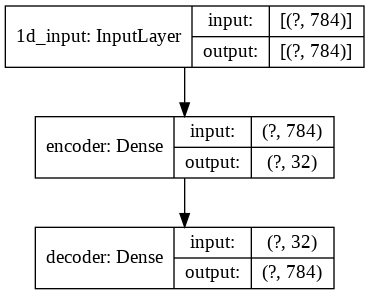

In [13]:
from tensorflow.keras.utils import plot_model

plot_model(autoencoder, show_shapes=True, dpi=dpi)

In [0]:
from tensorflow import keras

@tf.function
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [16]:
%%time 

BATCH_SIZE = 256
EPOCHS = 50

autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=[rounded_accuracy])
# also possible
# autoencoder.compile(optimizer='adam', loss='mse')

# we expect 0.09 for mninst and around 0.28 for fahshin mnist
history = autoencoder.fit(x = x_train,
                    y = x_train,
                    validation_data=(x_test, x_test),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 1min 1s, sys: 5.32 s, total: 1min 6s
Wall time: 44.6 s


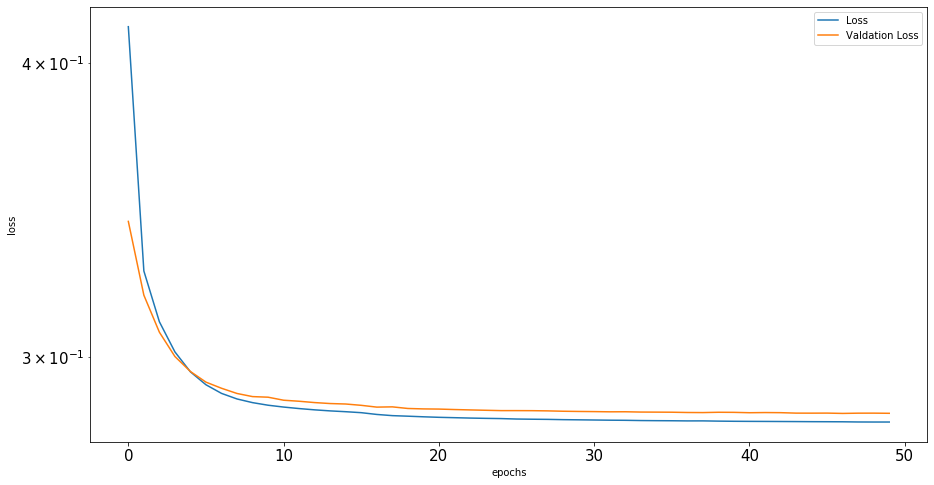

In [17]:
plt.yscale('log')

plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(["Loss", "Valdation Loss"]);

In [0]:
encoder = Model(input_img, encoded)

encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.get_layer('decoder')
decoder = Model(encoded_input, decoder_layer(encoded_input))

embedded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(embedded_imgs)

In [0]:
# shortcut
# x_test_pred = autoencoder.predict(x_test)
x_test_pred = decoded_imgs

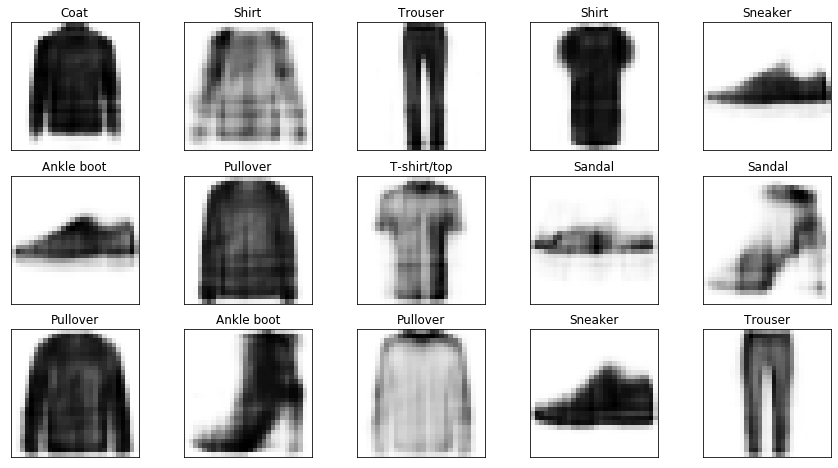

In [20]:
plot_samples(x_test_pred, y_test, labels=fashion_mnist_labels)

In [0]:
def compare_samples(x, x_pred, n_samples=5):
  figure = plt.figure()
  for i, index in enumerate(np.random.choice(x_test.shape[0], size=n_samples, replace=False)):
      ax = figure.add_subplot(2, n_samples, i + 1, xticks=[], yticks=[])
      ax.imshow(x[index].reshape(x_res, y_res), cmap="binary")
      ax = figure.add_subplot(2, n_samples, i + 1 + n_samples, xticks=[], yticks=[])
      ax.imshow(x_pred[index].reshape(x_res, y_res), cmap="binary")

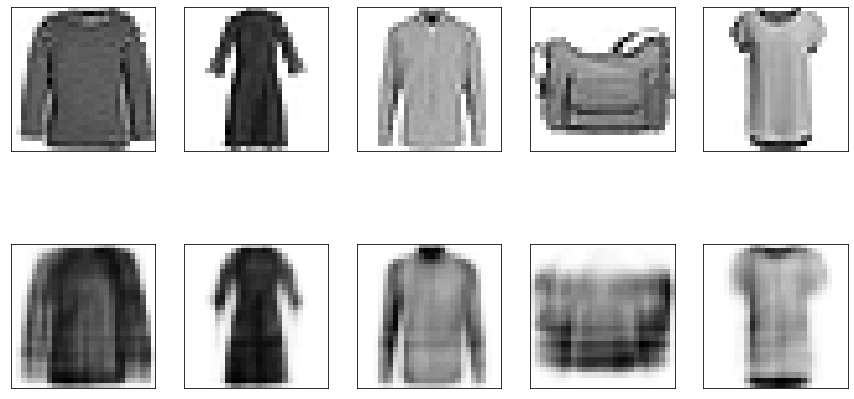

In [22]:
compare_samples(x_test, x_test_pred)

## let's consider the sparsity of an embedding 
### how big are the embeddings on avearge and how many zeros do the embeddings contain on average

In [23]:
embedded_imgs.shape

(10000, 32)

In [24]:
# embedding for first image
embedded_imgs[0]

array([ 3.1210299, 10.62313  ,  3.5537248,  0.       ,  2.4922104,
        2.6944351,  5.20557  ,  0.       ,  2.8162818,  5.122649 ,
        6.084511 ,  8.634408 ,  7.7251353,  6.475154 ,  2.201939 ,
        3.2114155,  9.081033 ,  6.539796 ,  8.107544 ,  8.285535 ,
        4.274202 ,  4.0374966,  8.71369  ,  4.857599 ,  2.3575735,
        3.867898 ,  5.9518137,  1.8000925,  3.362134 ,  7.1348   ,
        0.8820393,  3.4520063], dtype=float32)

In [25]:
tf.reduce_mean(embedded_imgs)

<tf.Tensor: shape=(), dtype=float32, numpy=4.580519>

In [26]:
# how many zeros do the embeddings contain on average
tf.reduce_mean(32 - tf.math.count_nonzero(embedded_imgs, axis=1))

<tf.Tensor: shape=(), dtype=int64, numpy=3>

## Exercise

Experiment with
* the size of the embedding
* MSE as a loss function
* mnist digits dataset instead of fashin mninst

# STOP HERE

## Adding sparsity

In [27]:
from tensorflow.keras import regularizers

encoding_dim = 32

input_img = Input(shape=(image_size,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(1e-3))(input_img)
decoded = Dense(784, activation='sigmoid', name='decoder')(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
decoder (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [28]:
%%time 

BATCH_SIZE = 256
EPOCHS = 100

autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=[rounded_accuracy])

# we expect 0.09 for mninst and around 0.28 for fahshin mnist
history = autoencoder.fit(x = x_train,
                    y = x_train,
                    validation_data=(x_test, x_test),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    callbacks=[KerasLearningCurve()],
                    verbose=0)

CPU times: user 2min 9s, sys: 11.5 s, total: 2min 21s
Wall time: 1min 33s


In [0]:
encoder = Model(input_img, encoded)

encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.get_layer('decoder')
decoder = Model(encoded_input, decoder_layer(encoded_input))

embedded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(embedded_imgs)

numbers of zeros should go up, while average should go down

In [30]:
# embedding for first image
embedded_imgs[0]

array([0.        , 0.        , 0.56262326, 0.        , 0.        ,
       0.        , 1.1256826 , 0.21185037, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02563743, 0.40184388, 0.22819152, 0.        ,
       0.18073533, 0.        , 0.88656664, 0.08611283, 0.1274799 ,
       0.77855223, 0.        , 0.        , 0.        , 0.        ,
       0.34216648, 0.        ], dtype=float32)

In [31]:
tf.reduce_mean(embedded_imgs), tf.reduce_mean(32 - tf.math.count_nonzero(embedded_imgs, axis=1))

(<tf.Tensor: shape=(), dtype=float32, numpy=0.14769888>,
 <tf.Tensor: shape=(), dtype=int64, numpy=19>)

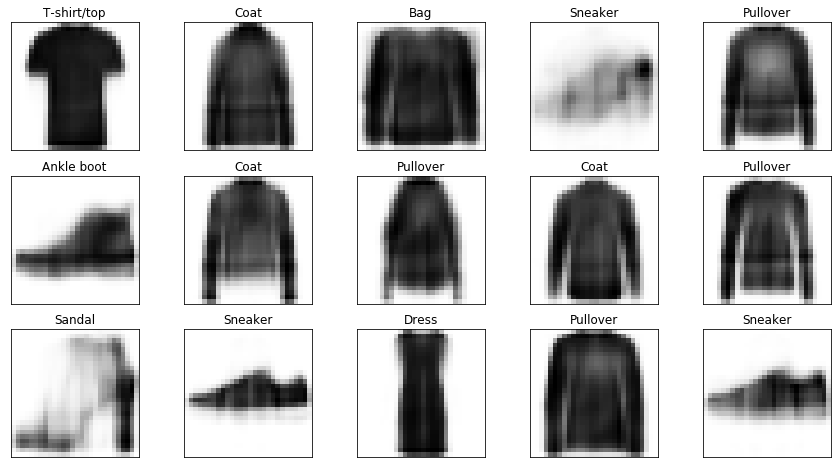

In [32]:
plot_samples(decoded_imgs, y_test, labels=fashion_mnist_labels)

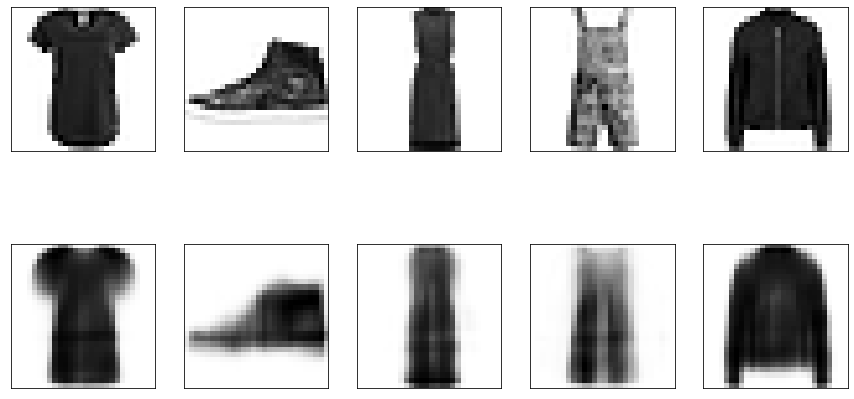

In [33]:
compare_samples(x_test, decoded_imgs)

## Deeper Autoencoder
https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb

In [34]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [35]:
%%time

BATCH_SIZE = 256
EPOCHS = 20

encoding_dim = 32

stacked_encoder = keras.models.Sequential([
    keras.layers.Input(shape=(x_res, y_res)),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(encoding_dim, activation="relu", activity_regularizer=keras.regularizers.l1(5e-4)),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Input(shape=encoding_dim),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(image_size, activation="sigmoid"),
    keras.layers.Reshape((x_res, y_res))
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer='adam', metrics=[rounded_accuracy])
history = stacked_ae.fit(x_train, x_train, 
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=(x_test, x_test),
                         callbacks=[KerasLearningCurve()],
                         verbose=0)


CPU times: user 28.4 s, sys: 2.14 s, total: 30.6 s
Wall time: 20.7 s


In [0]:
x_test_pred = stacked_ae.predict(x_test)

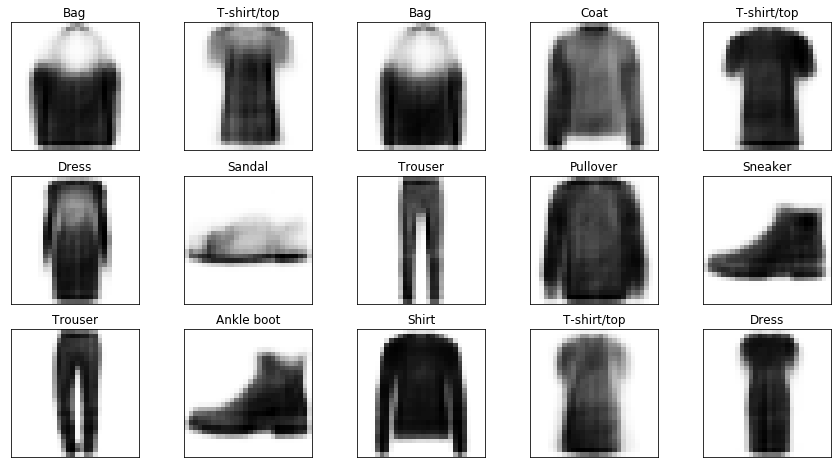

In [37]:
plot_samples(x_test_pred, y_test, labels=fashion_mnist_labels)

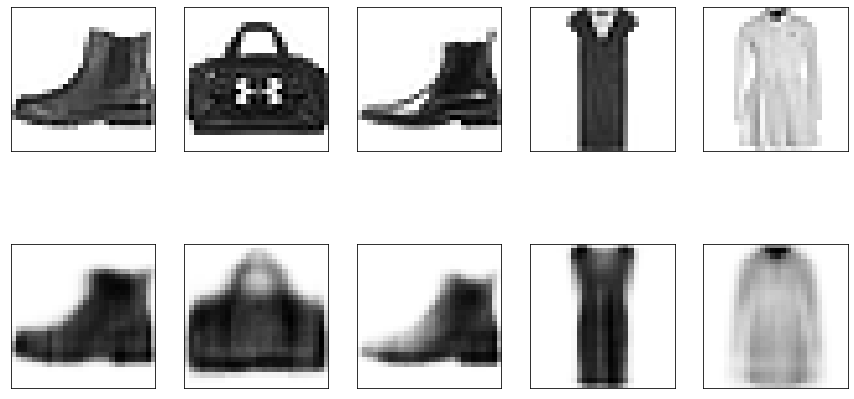

In [38]:
compare_samples(x_test, x_test_pred)

In [39]:
embedded_imgs = stacked_encoder.predict(x_test)
embedded_imgs.shape

(10000, 32)

In [40]:
embedded_imgs[0]

array([0.        , 0.        , 0.        , 0.        , 1.1122198 ,
       1.056637  , 0.        , 0.        , 0.        , 0.        ,
       0.1334006 , 0.04388085, 0.        , 0.7566045 , 0.        ,
       0.        , 0.6574748 , 2.6998527 , 0.17877081, 1.3427289 ,
       0.        , 0.3252666 , 0.2626537 , 0.        , 0.5168604 ,
       0.86152893, 0.8306811 , 0.16442646, 0.        , 0.3670865 ,
       0.        , 0.        ], dtype=float32)

In [41]:
tf.reduce_mean(embedded_imgs), tf.reduce_mean(32 - tf.math.count_nonzero(embedded_imgs, axis=1))

(<tf.Tensor: shape=(), dtype=float32, numpy=0.28347957>,
 <tf.Tensor: shape=(), dtype=int64, numpy=15>)

## Looking at our embeddings

In [0]:
# https://umap-learn.readthedocs.io/en/latest/basic_usage.html
# https://umap-learn.readthedocs.io/en/latest/how_umap_works.html
import umap

In [43]:
%%time

# https://umap-learn.readthedocs.io/en/latest/parameters.html
reducer = umap.UMAP(
#     n_neighbors=5, 
    random_state=42)
embeddings_2d = reducer.fit_transform(embedded_imgs)

CPU times: user 31.9 s, sys: 282 ms, total: 32.2 s
Wall time: 31.7 s


In [44]:
embeddings_2d.shape

(10000, 2)

In [45]:
# just to make it a little easier for us for offsets etc.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embeddings_2d = scaler.fit_transform(embeddings_2d)
embeddings_2d.shape

(10000, 2)

(-1.8693723253983139, 1.4248917870300888, -2.060955879232311, 2.5452648372859)

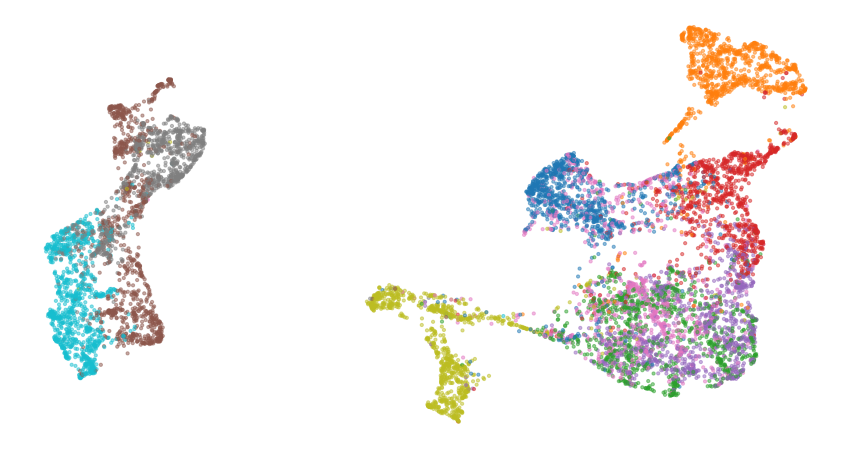

In [46]:
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap="tab10", alpha=0.5)
plt.axis("off")

(-1.8693723253983139, 1.4248917870300888, -2.060955879232311, 2.5452648372859)

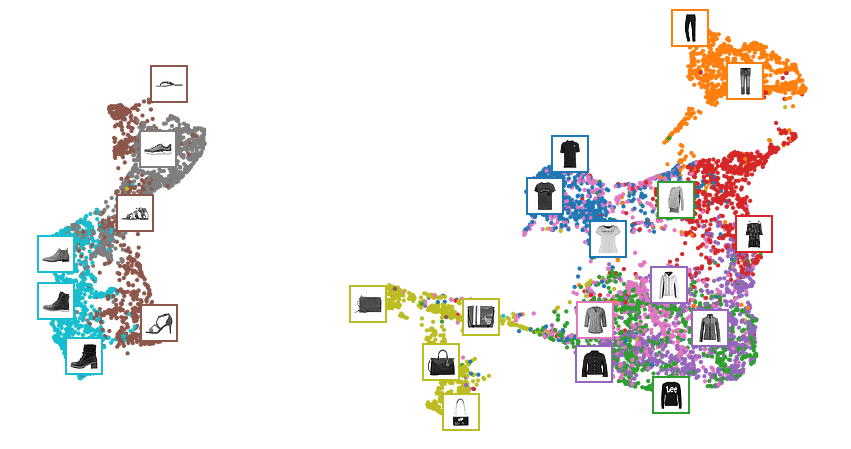

In [47]:
# from https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
cmap = plt.cm.tab10
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(embeddings_2d):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.2: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_test[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_test[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")

## Using 2d embeddings directly without UMAP dimensionality reduction

In [48]:
%%time

BATCH_SIZE = 2048
EPOCHS = 100

encoding_dim = 2

stacked_encoder = keras.models.Sequential([
    keras.layers.Input(shape=(x_res, y_res)),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(encoding_dim, activation="relu",
                       activity_regularizer=keras.regularizers.l1(1e-5)
                      )
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Input(shape=encoding_dim),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(image_size, activation="sigmoid"),
    keras.layers.Reshape((x_res, y_res))
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer='adam', metrics=[rounded_accuracy])
history = stacked_ae.fit(x_train, x_train, 
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=(x_test, x_test),
                         callbacks=[KerasLearningCurve()],
                         verbose=0)


CPU times: user 46.3 s, sys: 2.77 s, total: 49.1 s
Wall time: 33.2 s


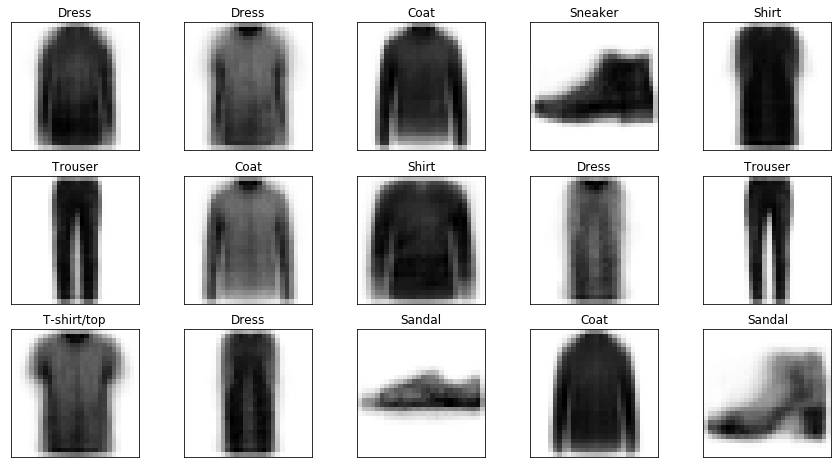

In [49]:
x_test_pred = stacked_ae.predict(x_test)
plot_samples(x_test_pred, y_test, labels=fashion_mnist_labels)

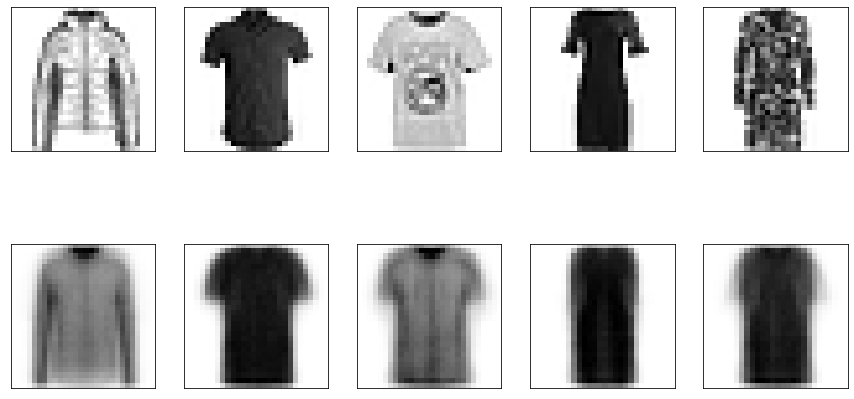

In [50]:
compare_samples(x_test, x_test_pred)

In [51]:
embedded_imgs = stacked_encoder.predict(x_test)
embedded_imgs.shape

(10000, 2)

In [52]:
embedded_imgs[0]

array([ 6.8606215, 20.25099  ], dtype=float32)

In [53]:
tf.reduce_mean(embedded_imgs), tf.reduce_mean(2.0 - tf.cast(tf.math.count_nonzero(embedded_imgs, axis=1), tf.float32))

(<tf.Tensor: shape=(), dtype=float32, numpy=17.000826>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0111>)

In [0]:
embeddings_2d = embedded_imgs

In [55]:
# just to make it a little easier for us for offsets etc.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embeddings_2d = scaler.fit_transform(embeddings_2d)
embeddings_2d.shape

(10000, 2)

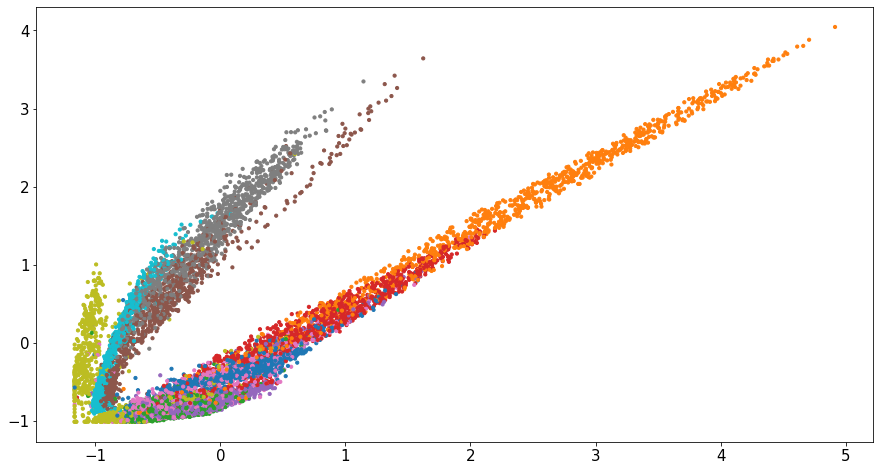

In [56]:
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap=cmap)

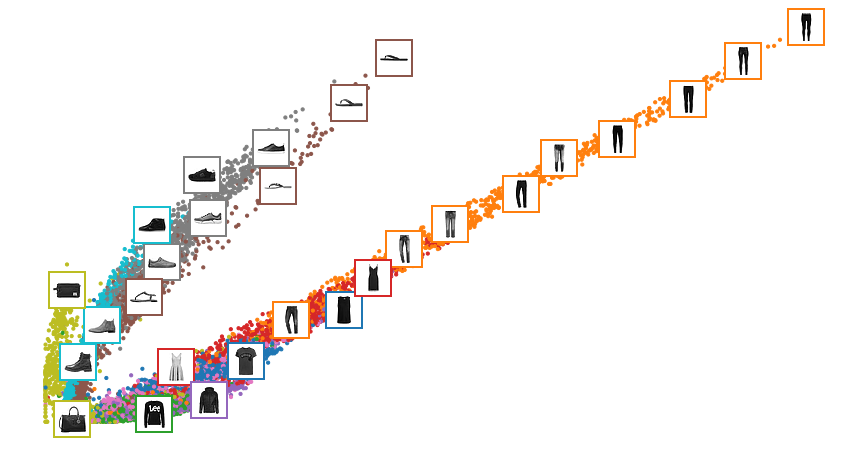

In [57]:
min_dist = 0.2

# from https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
cmap = plt.cm.tab10
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(embeddings_2d):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > min_dist: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_test[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_test[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off");

## Convolutional Autoencoders

In [58]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Reshape
from tensorflow.keras.models import Model, Sequential

conv_encoder = Sequential([
    Input(shape=(x_res, y_res)),
    Reshape((x_res, y_res, 1)),
    Conv2D(16, kernel_size=3, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2)
])

# https://machinelearningmastery.com/upsampling-and-transpose-convolution-layers-for-generative-adversarial-networks/
conv_decoder = Sequential([
    Conv2DTranspose(32, kernel_size=3, strides=2, padding="valid", activation="relu",
                                 input_shape=[3, 3, 64]),
    Conv2DTranspose(16, kernel_size=3, strides=2, padding="same", activation="relu"),
    Conv2DTranspose(1, kernel_size=3, strides=2, padding="same", activation="sigmoid"),
    Reshape((x_res, y_res))
])
conv_ae = Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer='adam', metrics=[rounded_accuracy])

conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)         

In [59]:
%%time

BATCH_SIZE = 2048
EPOCHS = 50

history = conv_ae.fit(x_train, x_train, 
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=(x_test, x_test),
                         callbacks=[KerasLearningCurve()],
                         verbose=0)

CPU times: user 35.8 s, sys: 8.6 s, total: 44.4 s
Wall time: 46.7 s


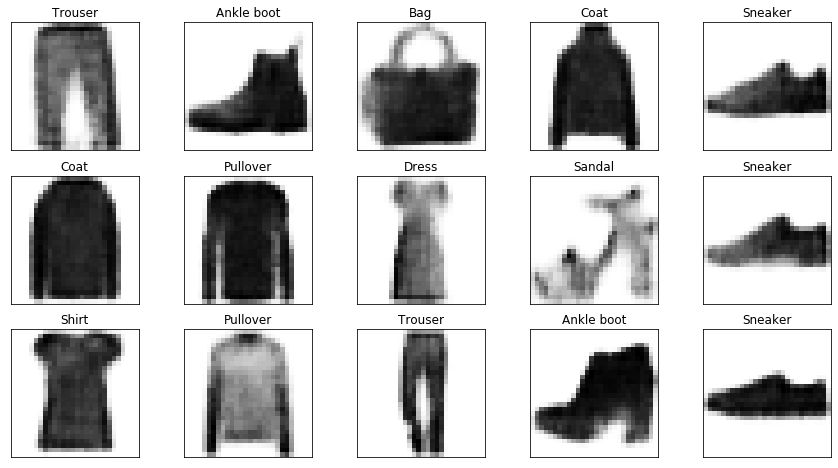

In [60]:
x_test_pred = conv_ae.predict(x_test)
plot_samples(x_test_pred, y_test, labels=fashion_mnist_labels)

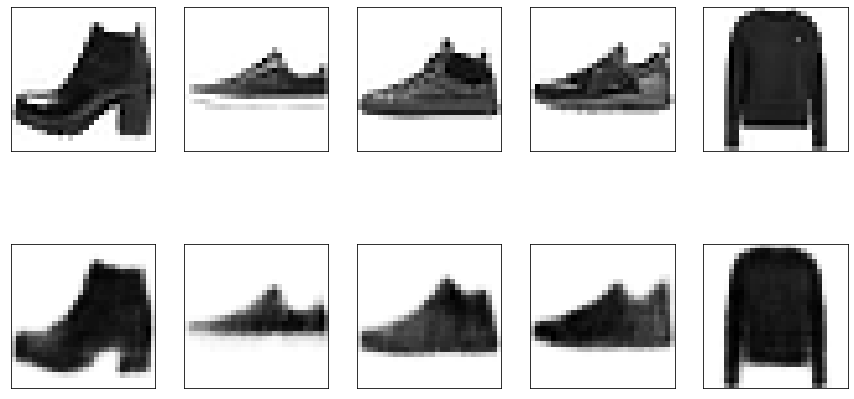

In [61]:
compare_samples(x_test, x_test_pred)

## Now putting an explicit 2 dim latent space in between as a bottleneck

In [62]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Reshape
from tensorflow.keras.models import Model, Sequential

encoding_dim = 2

conv_encoder = Sequential([
    Input(shape=(x_res, y_res)),
    Reshape((x_res, y_res, 1)),
    Conv2D(16, kernel_size=3, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(encoding_dim, activation="relu", activity_regularizer=keras.regularizers.l1(1e-5)),

])
conv_decoder = Sequential([
    Input(shape=(encoding_dim)),
    Reshape((1, 1, encoding_dim)),
    Conv2DTranspose(32, kernel_size=3, strides=2, padding="valid", activation="relu"),
    Conv2DTranspose(16, kernel_size=3, strides=2, padding="valid", activation="relu"),
    Conv2DTranspose(8, kernel_size=3, strides=2, padding="same", activation="relu"),
    Conv2DTranspose(1, kernel_size=3, strides=2, padding="same", activation="sigmoid"),
    Reshape((x_res, y_res))
])
conv_ae = Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer='adam', metrics=[rounded_accuracy])

conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_4 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 64)         

In [63]:
%%time

BATCH_SIZE = 2048
EPOCHS = 50

history = conv_ae.fit(x_train, x_train, 
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=(x_test, x_test),
                         callbacks=[KerasLearningCurve()],
                         verbose=0)

CPU times: user 35.8 s, sys: 7.46 s, total: 43.3 s
Wall time: 43.1 s


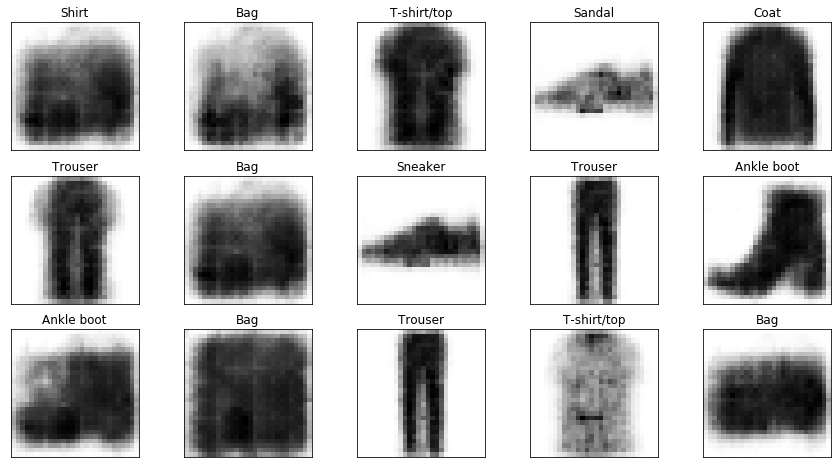

In [64]:
x_test_pred = conv_ae.predict(x_test)
plot_samples(x_test_pred, y_test, labels=fashion_mnist_labels)

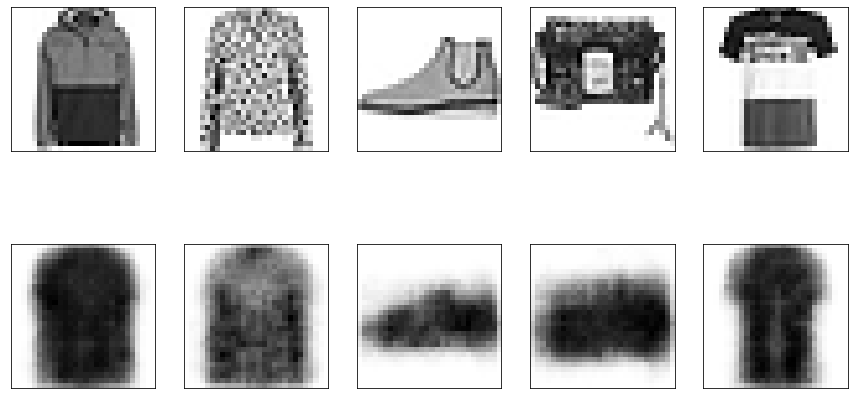

In [65]:
compare_samples(x_test, x_test_pred)

In [66]:
embedded_imgs = conv_encoder.predict(x_test)
embedded_imgs.shape

(10000, 2)

In [67]:
embedded_imgs[0]

array([70.50721 , 28.260214], dtype=float32)

In [68]:
tf.reduce_mean(embedded_imgs), tf.reduce_mean(2.0 - tf.cast(tf.math.count_nonzero(embedded_imgs, axis=1), tf.float32))

(<tf.Tensor: shape=(), dtype=float32, numpy=44.89779>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0325>)

In [0]:
embeddings_2d = embedded_imgs

In [70]:
# just to make it a little easier for us for offsets etc.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embeddings_2d = scaler.fit_transform(embeddings_2d)
embeddings_2d.shape

(10000, 2)

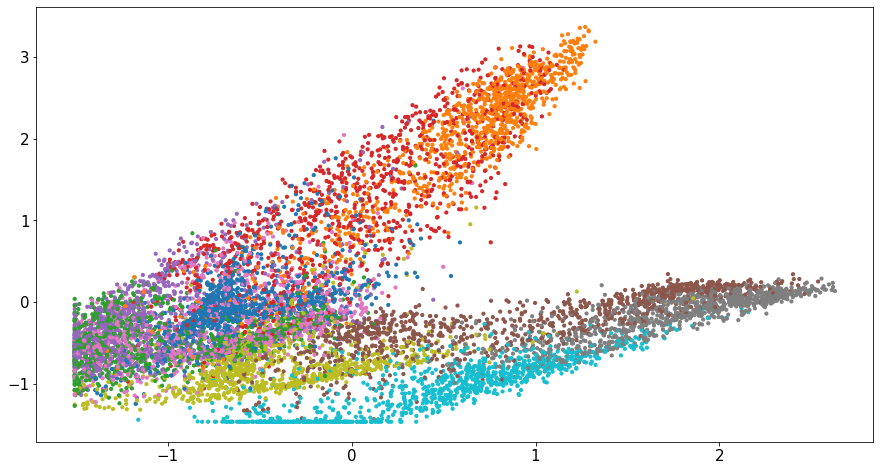

In [71]:
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap=cmap);

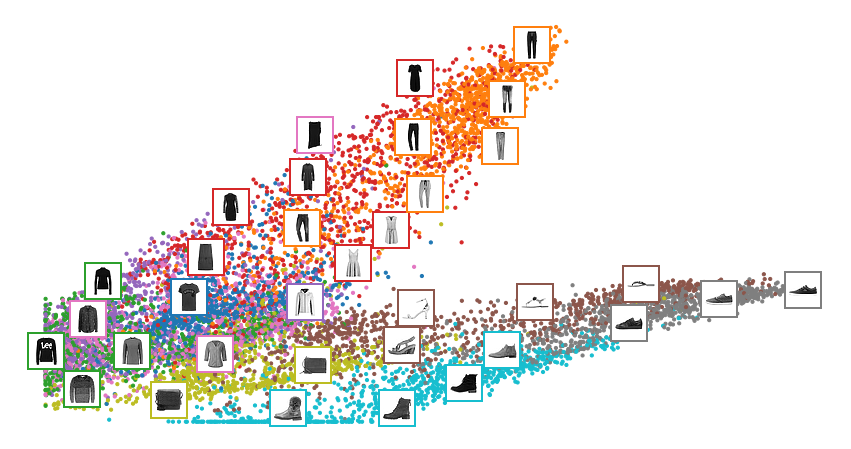

In [72]:
min_dist = 0.2

# from https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
cmap = plt.cm.tab10
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(embeddings_2d):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > min_dist: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_test[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_test[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off");

## Now 32 spars dims

In [73]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Reshape
from tensorflow.keras.models import Model, Sequential

encoding_dim = 32

conv_encoder = Sequential([
    Input(shape=(x_res, y_res)),
    Reshape((x_res, y_res, 1)),
    Conv2D(16, kernel_size=3, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    MaxPooling2D(pool_size=2),
    Flatten(),
    Dense(encoding_dim, activation="relu", activity_regularizer=keras.regularizers.l1(1e-4)),

])
conv_decoder = Sequential([
    Input(shape=(encoding_dim)),
    Reshape((1, 1, encoding_dim)),
    Conv2DTranspose(32, kernel_size=3, strides=2, padding="valid", activation="relu"),
    Conv2DTranspose(16, kernel_size=3, strides=2, padding="valid", activation="relu"),
    Conv2DTranspose(8, kernel_size=3, strides=2, padding="same", activation="relu"),
    Conv2DTranspose(1, kernel_size=3, strides=2, padding="same", activation="sigmoid"),
    Reshape((x_res, y_res))
])
conv_ae = Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="binary_crossentropy", optimizer='adam', metrics=[rounded_accuracy])

conv_encoder.summary()
conv_decoder.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 3, 3, 64)        

In [74]:
%%time

BATCH_SIZE = 2048
EPOCHS = 50

history = conv_ae.fit(x_train, x_train, 
                         epochs=EPOCHS,
                         batch_size=BATCH_SIZE,
                         validation_data=(x_test, x_test),
                         callbacks=[KerasLearningCurve()],
                         verbose=0)

CPU times: user 35.9 s, sys: 7.5 s, total: 43.4 s
Wall time: 43.7 s


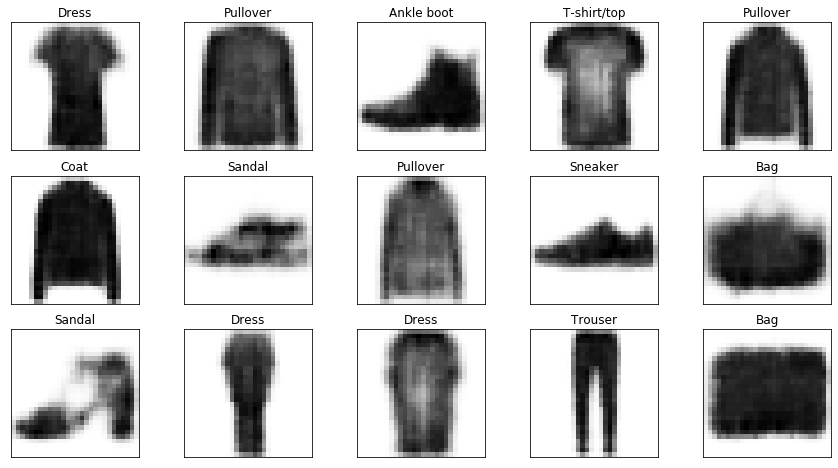

In [75]:
x_test_pred = conv_ae.predict(x_test)
plot_samples(x_test_pred, y_test, labels=fashion_mnist_labels)

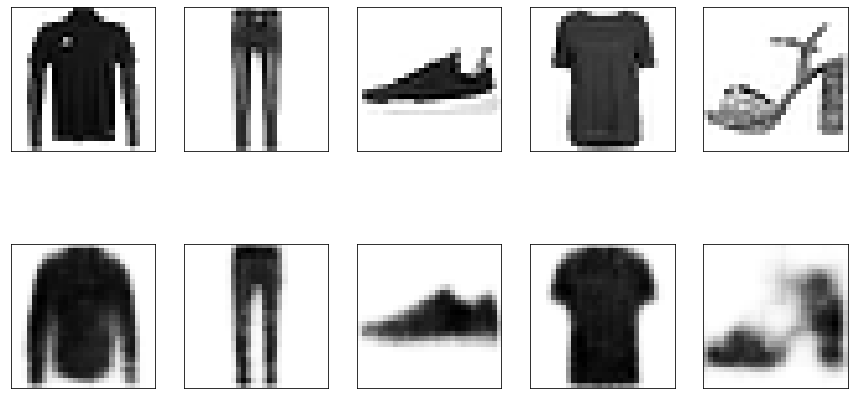

In [100]:
compare_samples(x_test, x_test_pred)

In [87]:
embedded_imgs = conv_encoder.predict(x_test)
embedded_imgs.shape

(10000, 32)

In [88]:
embedded_imgs[0]

array([0.       , 3.3853364, 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       1.8084966, 0.       , 0.       , 0.       , 0.       , 6.453443 ,
       0.       , 0.       , 3.315411 , 6.3460655, 0.4578176, 0.       ,
       0.9929453, 0.       , 0.       , 0.       , 0.       , 1.433485 ,
       0.       , 0.       ], dtype=float32)

In [89]:
tf.reduce_mean(embedded_imgs), tf.reduce_mean(32.0 - tf.cast(tf.math.count_nonzero(embedded_imgs, axis=1), tf.float32))

(<tf.Tensor: shape=(), dtype=float32, numpy=0.68613>,
 <tf.Tensor: shape=(), dtype=float32, numpy=24.402>)

In [0]:
embeddings_2d = embedded_imgs

In [91]:
%%time

# https://umap-learn.readthedocs.io/en/latest/parameters.html
reducer = umap.UMAP(
#     n_neighbors=5, 
    random_state=42)
embeddings_2d = reducer.fit_transform(embeddings_2d)

CPU times: user 28.1 s, sys: 291 ms, total: 28.4 s
Wall time: 27.8 s


In [95]:
# just to make it a little easier for us for offsets etc.
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
embeddings_2d = scaler.fit_transform(embeddings_2d)
embeddings_2d.shape

(10000, 2)

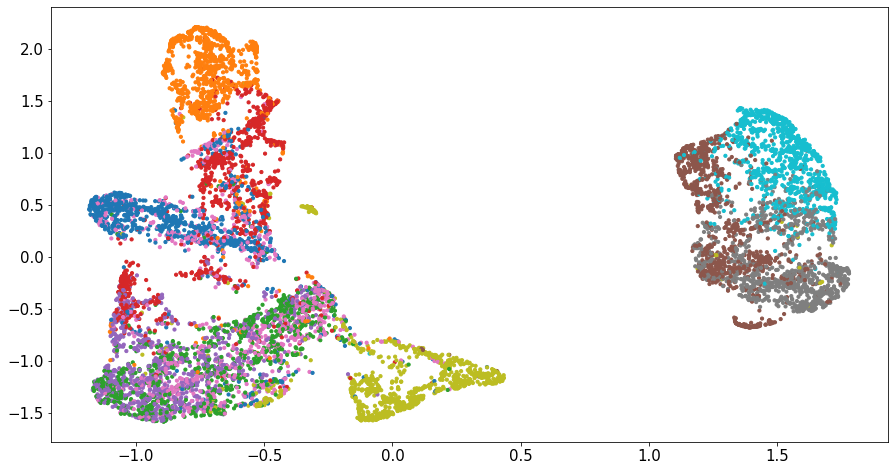

In [96]:
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap=cmap);

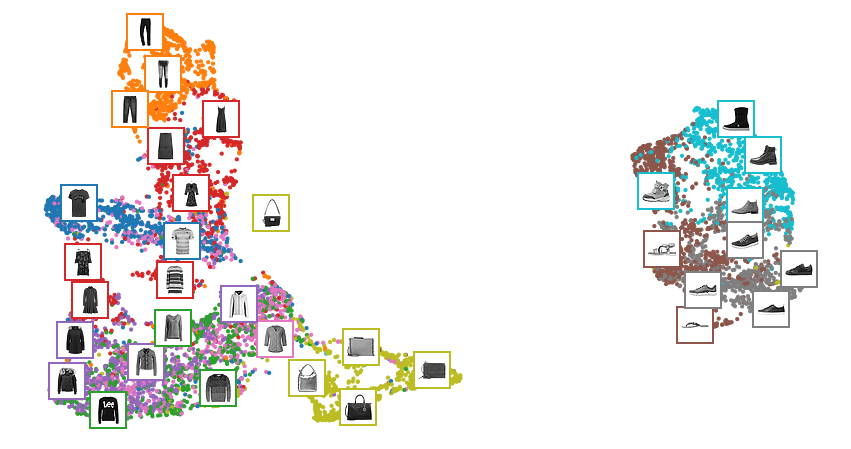

In [98]:
min_dist = 0.1

# from https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
cmap = plt.cm.tab10
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=y_test, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(embeddings_2d):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > min_dist: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(x_test[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_test[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off");